# Import packages

In [104]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import geopandas as gpd
import scipy
from scipy import optimize
from scipy import ndimage
from scipy.spatial import Voronoi
from scipy.stats import powerlaw
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping
from shapely import wkt, geometry
from shapely.wkt import loads
import sys
import pyproj as proj
from geopandas import GeoDataFrame
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)
from matplotlib.collections import LineCollection

pylab.rcParams['figure.figsize'] = 10, 8

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import fiona; help(fiona.open)

Help on function open in module fiona:

open(fp, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None, **kwargs)
    Open a collection for read, append, or write
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings like
    
      {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'W

# Load data

Set CRS variables:

In [3]:
crs_degree = {'init' :'epsg:4326'}
crs_meters = {'init': 'epsg:2161'}
epsg_degree=4326
epsg_meters=2161

Set filepath:

In [4]:
path = "data/FINAL/"

Upload administrative boundary:

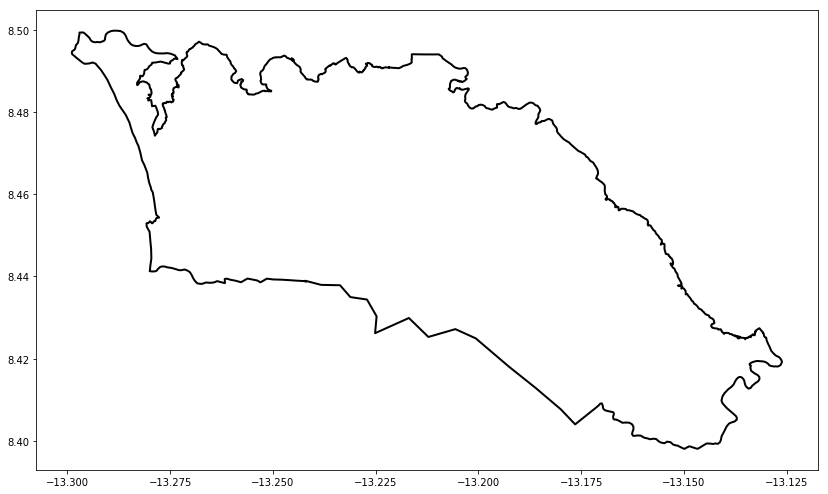

In [5]:
boundary = gpd.read_file(path+'CityBoundarywithRegent.shp')
boundary.crs = crs_degree
boundary.plot(color='none', edgecolor='black', linewidth=2, figsize=(14,10))

Upload edited administrative boundary which encompasses bridges:

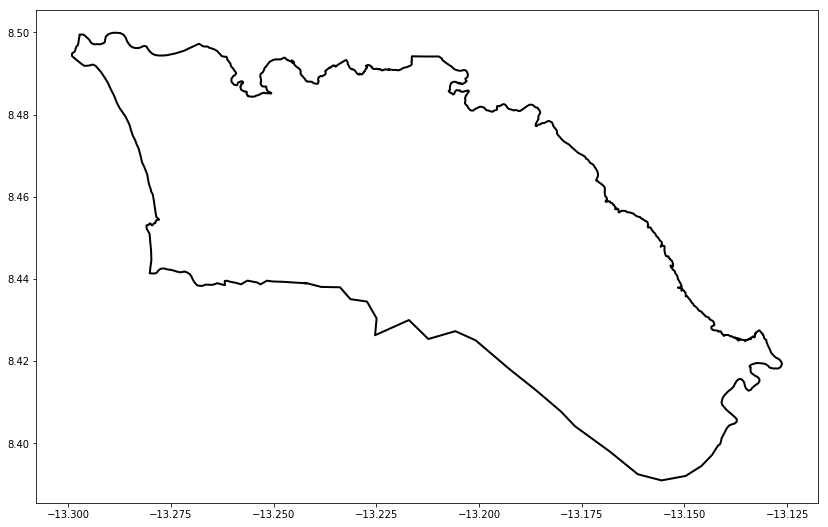

In [6]:
boundary2 = gpd.read_file(path+'CityBoundarywithRegent3.shp').to_crs(epsg=epsg_degree)
boundary2.plot(color='none', edgecolor='black', linewidth=2, figsize=(14,10))

Upload POI:

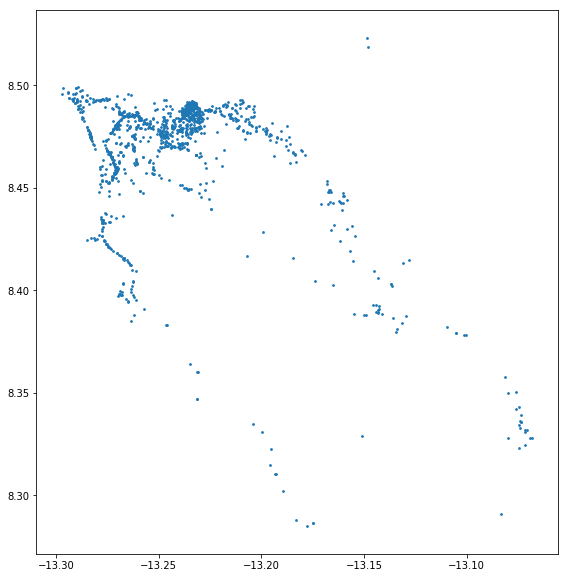

In [7]:
POI = pd.read_csv(path+'locations5.csv')
geometry = [Point(xy) for xy in zip(POI.long, POI.lat)]
geoPOI = GeoDataFrame(POI, crs=crs_degree, geometry=geometry)
geoPOI.plot(markersize=3, figsize=(14,10));

Upload Cell Phone Tower Positions:

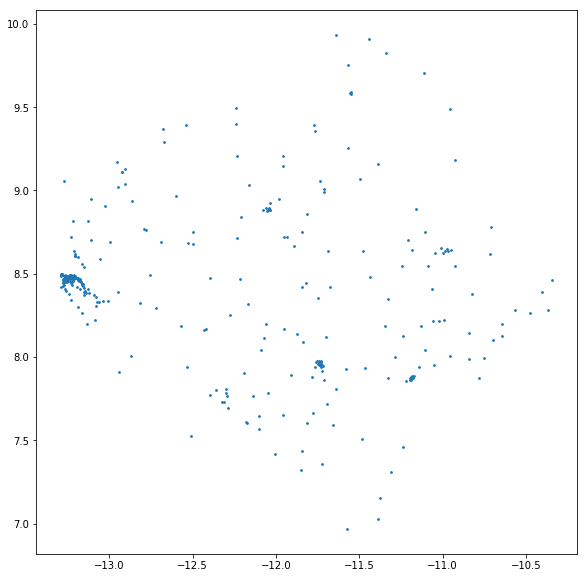

In [8]:
celltowers = pd.read_csv(path+'orange-loc-coordinates-v2.csv')
geometrycelltowers = [Point(xy) for xy in zip(celltowers.lon, celltowers.lat)]
geocelltowers = GeoDataFrame(celltowers, crs=crs_degree, geometry=geometrycelltowers)
geocelltowers.plot(markersize=3, figsize=(14,10));

Upload Population Centroids:

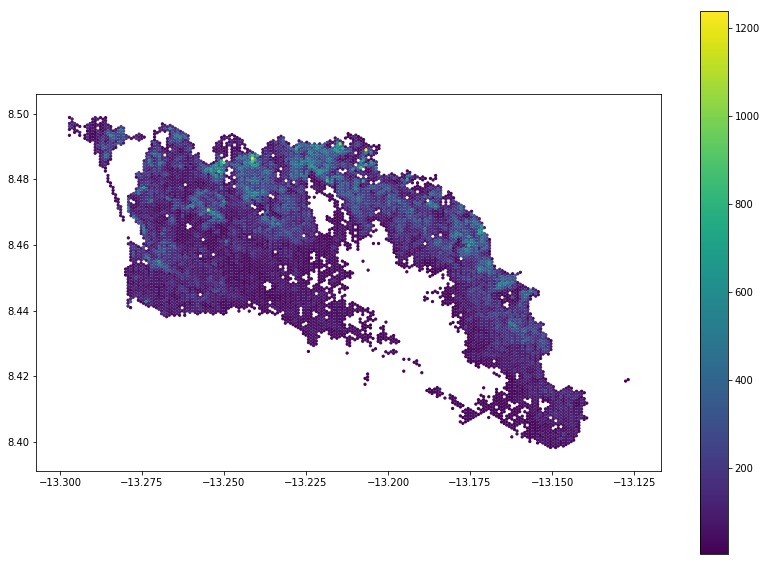

In [9]:
popcentroids = gpd.read_file(path+'PopCentroids.shp').to_crs(epsg=4326)
popcentroids.plot(markersize=5,column='sum_est_po', legend=True,figsize=(14,10))

# Create Polygons from Voronoi Diagram of Cell Towers to Function as TAZ

Create voronoi diagram:

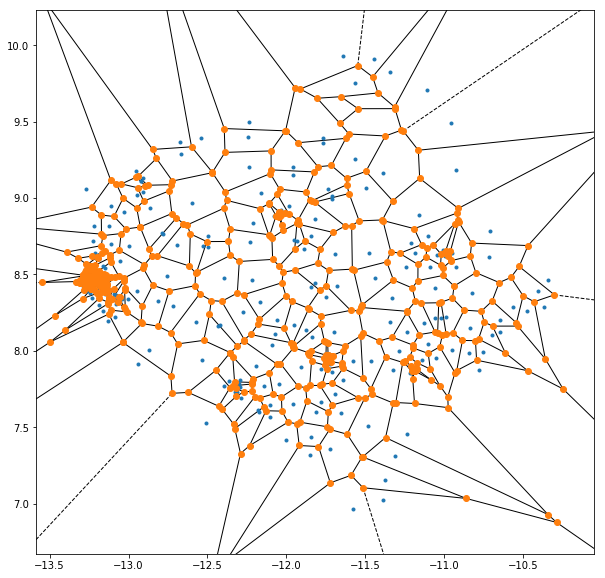

In [10]:
vor = Voronoi(np.array(list(zip(celltowers.lon, celltowers.lat))))
plt.rcParams["figure.figsize"] = [10,10]
scipy.spatial.voronoi_plot_2d(vor)
plt.show()

Define a function to write voronoi diagram to shapefile as polygons:

In [11]:
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

Run function:

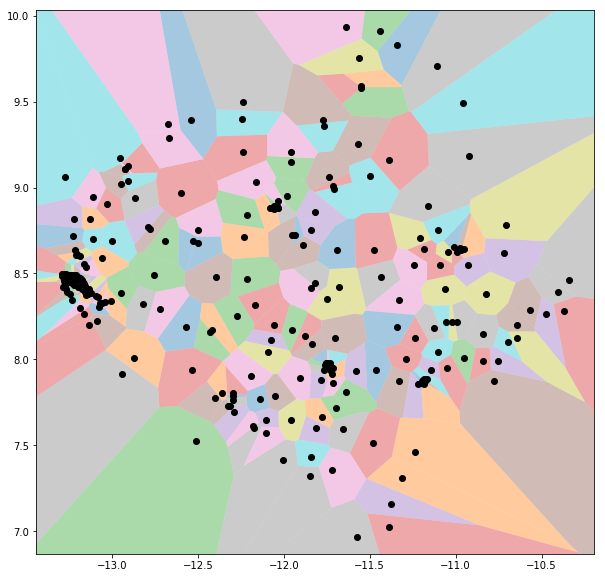

In [12]:
regions, vertices = voronoi_finite_polygons_2d(vor)
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
#    poly = Polygon(polygon)
#    poly = poly.intersection(boundary['geometry'][0])
#    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(np.array(list(zip(celltowers.lon, celltowers.lat)))[:, 0], np.array(list(zip(celltowers.lon, celltowers.lat)))[:, 1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
plt.show()

Write to shapefile:

In [13]:
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open(path+'vor.shp', 'w', 'ESRI Shapefile', schema) as c:
    for region in regions:
        polygon = vertices[region]
        poly = Polygon(polygon)
        c.write({
            'geometry': mapping(poly),
            'properties': {'id': 123},
        })

# Clip Zones, Calculate Centroids

Load voronoi shapefile as a geodataframe:

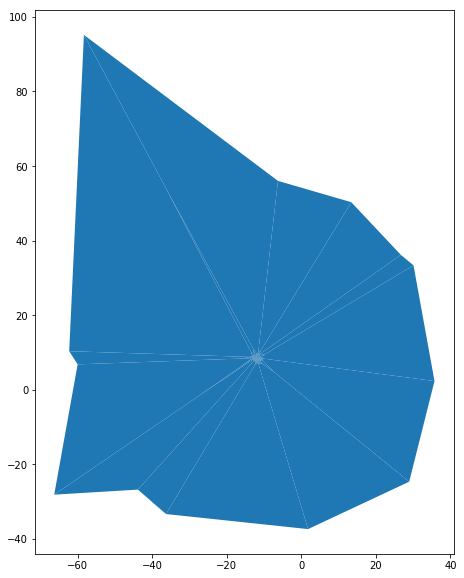

In [14]:
vorshape = gpd.read_file(path+'vor.shp')
vorshape.plot()

Clip voronoi polygons to freetown administrative boundary and save to file:

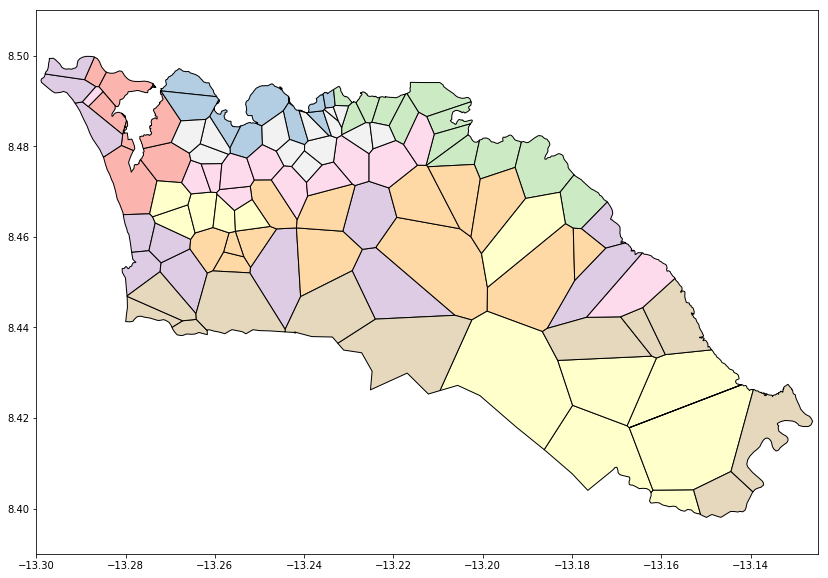

In [15]:
vorshape_clip = gpd.overlay(boundary, vorshape, how='intersection')
vorshape_clip.crs = crs_degree
vorshape_clip.to_file(driver='ESRI Shapefile',filename=path+'vorshape_clip.shp')
fig, ax = plt.subplots(figsize=(14,10))
vorshape_clip.plot(ax=ax,cmap='Pastel1',edgecolor='black', figsize=(14,10))
plt.xlim(-13.3, -13.125)
plt.ylim(8.39,8.51)
plt.show()

Calculate centroids and save to file:

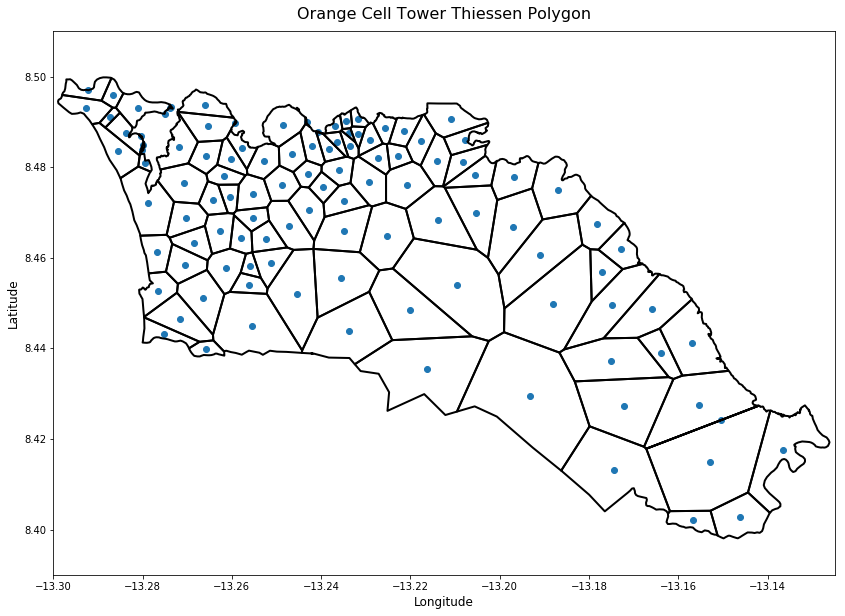

In [16]:
vorshape_clip = vorshape_clip.set_geometry('geometry')
vorshape_clip['centroid'] = vorshape_clip.centroid
vorshape_clip = vorshape_clip.set_geometry('centroid')
vorshape_clip_centroid = vorshape_clip.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22]]
vorshape_clip_centroid.head()
vorshape_clip_centroid.to_file(driver='ESRI Shapefile',filename='data/Assignment 7/vorshape_clip_centroid.shp')
vorshape_clip = vorshape_clip.set_geometry('geometry')

fig, ax = plt.subplots(figsize=(14,10))
vorshape_clip_centroid.plot(ax=ax)
#geocelltowers.plot(ax=ax)
vorshape_clip.plot(ax=ax,color='none', edgecolor='black', linewidth=2,);
plt.xlim(-13.3, -13.125)
plt.ylim(8.39,8.51)
plt.title("Orange Cell Tower Thiessen Polygon", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center', 
    pad=12)
plt.xlabel('Longitude',
    fontdict={'fontsize': 12})
plt.ylabel('Latitude',
    fontdict={'fontsize': 12})
plt.show()

# Aggregate Population and POI within Zones

Population:

In [17]:
#create permanent index for zones
vorshape_clip['index_col'] = vorshape_clip.index

#assign zone index to population centroids
pop_by_tract = gpd.sjoin(popcentroids, vorshape_clip, how="inner", op='intersects')

#aggregate by index
tract_tot_pop = pop_by_tract.groupby('index_col')['sum_est_po'].sum().to_frame(name='total_pop').reset_index()

#aggregate to zone
vorshape_clip = pd.merge(vorshape_clip,tract_tot_pop, on='index_col',how='left')
vorshape_clip.head()

OBJECTID_1  OBJECTID          admin2Name admin2Pcod          admin2RefN  \
0          14        14  Western Area Urban     SL0402  Western Area Urban   
1          14        14  Western Area Urban     SL0402  Western Area Urban   
2          14        14  Western Area Urban     SL0402  Western Area Urban   
3          14        14  Western Area Urban     SL0402  Western Area Urban   
4          14        14  Western Area Urban     SL0402  Western Area Urban   

  admin2AltN admin2Al_1 admin1Name admin1Pcod    admin0Name    ...      \
0       None       None    Western       SL04  Sierra Leone    ...       
1       None       None    Western       SL04  Sierra Leone    ...       
2       None       None    Western       SL04  Sierra Leone    ...       
3       None       None    Western       SL04  Sierra Leone    ...       
4       None       None    Western       SL04  Sierra Leone    ...       

  Rowcacode0 Rowcacode1 Rowcacode2 Shape_Le_1  Shape_Area   id  \
0        SLE     SLE004  SLE004002   0.738327    0.006069  123   
1        SLE     SLE004  SLE004002   0.738327    0.006069  123   
2        SLE     SLE004  SLE004002   0.738327    0.006069  123   
3        SLE     SLE004  SLE004002   0.738327    0.006069  123   
4        SLE     SLE004  SLE004002   0.738327    0.006069  123   

                                            geometry  \
0  POLYGON ((-13.28529231399993 8.49735420400007,...   
1  POLYGON ((-13.2842706294093 8.49633968786792, ...   
2  POLYGON ((-13.27391346199055 8.493822439167344...   
3  POLYGON ((-13.27324437213796 8.492925606268972...   
4  POLYGON ((-13.27505224256096 8.491871380736733...   

                                       centroid  index_col  total_pop  
0   POINT (-13.2867208880282 8.496025583928487)          0     1865.0  
1  POINT (-13.28095843311184 8.493125710292972)          1    10865.0  
2  POINT (-13.27367646829555 8.493370799173581)          2        NaN  
3  POINT (-13.27387682996853 8.493045970412151)          3        NaN  
4  POINT (-13.27507617641929 8.491827705718965)          4        NaN  

[5 rows x 25 columns]

POI:

In [18]:
#assign zone index to POI
POI_by_tract = gpd.sjoin(geoPOI, vorshape_clip, how="inner", op='intersects')

#aggregate by index
tract_tot_POI = POI_by_tract.groupby('index_col')['type1'].count().to_frame(name='total_POI').reset_index()

#aggregate to zone
vorshape_clip = pd.merge(vorshape_clip,tract_tot_POI, on='index_col',how='left')
vorshape_clip = vorshape_clip.fillna(0)
vorshape_clip.head()

OBJECTID_1  OBJECTID          admin2Name admin2Pcod          admin2RefN  \
0          14        14  Western Area Urban     SL0402  Western Area Urban   
1          14        14  Western Area Urban     SL0402  Western Area Urban   
2          14        14  Western Area Urban     SL0402  Western Area Urban   
3          14        14  Western Area Urban     SL0402  Western Area Urban   
4          14        14  Western Area Urban     SL0402  Western Area Urban   

   admin2AltN  admin2Al_1 admin1Name admin1Pcod    admin0Name    ...      \
0           0           0    Western       SL04  Sierra Leone    ...       
1           0           0    Western       SL04  Sierra Leone    ...       
2           0           0    Western       SL04  Sierra Leone    ...       
3           0           0    Western       SL04  Sierra Leone    ...       
4           0           0    Western       SL04  Sierra Leone    ...       

  Rowcacode1 Rowcacode2 Shape_Le_1  Shape_Area   id  \
0     SLE004  SLE004002   0.738327    0.006069  123   
1     SLE004  SLE004002   0.738327    0.006069  123   
2     SLE004  SLE004002   0.738327    0.006069  123   
3     SLE004  SLE004002   0.738327    0.006069  123   
4     SLE004  SLE004002   0.738327    0.006069  123   

                                            geometry  \
0  POLYGON ((-13.28529231399993 8.49735420400007,...   
1  POLYGON ((-13.2842706294093 8.49633968786792, ...   
2  POLYGON ((-13.27391346199055 8.493822439167344...   
3  POLYGON ((-13.27324437213796 8.492925606268972...   
4  POLYGON ((-13.27505224256096 8.491871380736733...   

                                       centroid index_col  total_pop  \
0   POINT (-13.2867208880282 8.496025583928487)         0     1865.0   
1  POINT (-13.28095843311184 8.493125710292972)         1    10865.0   
2  POINT (-13.27367646829555 8.493370799173581)         2        0.0   
3  POINT (-13.27387682996853 8.493045970412151)         3        0.0   
4  POINT (-13.27507617641929 8.491827705718965)         4        0.0   

   total_POI  
0        4.0  
1       21.0  
2        0.0  
3        1.0  
4        0.0  

[5 rows x 26 columns]

Calculate Area and Densities:

In [19]:
vorshape_clip_proj = vorshape_clip.to_crs(epsg=epsg_meters)
vorshape_clip_proj["area"] = vorshape_clip_proj['geometry'].area/10**6
vorshape_clip_proj["POI_dens"] = vorshape_clip_proj['total_POI']/vorshape_clip_proj['area']
vorshape_clip_proj["pop_dens"] = vorshape_clip_proj['total_pop']/vorshape_clip_proj['area']
vorshape_clip = vorshape_clip_proj.to_crs(epsg=epsg_degree)
vorshape_clip.head()

OBJECTID_1  OBJECTID          admin2Name admin2Pcod          admin2RefN  \
0          14        14  Western Area Urban     SL0402  Western Area Urban   
1          14        14  Western Area Urban     SL0402  Western Area Urban   
2          14        14  Western Area Urban     SL0402  Western Area Urban   
3          14        14  Western Area Urban     SL0402  Western Area Urban   
4          14        14  Western Area Urban     SL0402  Western Area Urban   

   admin2AltN  admin2Al_1 admin1Name admin1Pcod    admin0Name      ...       \
0           0           0    Western       SL04  Sierra Leone      ...        
1           0           0    Western       SL04  Sierra Leone      ...        
2           0           0    Western       SL04  Sierra Leone      ...        
3           0           0    Western       SL04  Sierra Leone      ...        
4           0           0    Western       SL04  Sierra Leone      ...        

  Shape_Area   id                                           geometry  \
0   0.006069  123  POLYGON ((-13.28529231321292 8.497354203475437...   
1   0.006069  123  POLYGON ((-13.28427062862237 8.496339687342791...   
2   0.006069  123  POLYGON ((-13.27391346120447 8.493822438640978...   
3   0.006069  123  POLYGON ((-13.27324437135193 8.49292560574216,...   
4   0.006069  123  POLYGON ((-13.2750522417748 8.491871380209387,...   

                                       centroid  index_col total_pop  \
0   POINT (-13.2867208880282 8.496025583928487)          0    1865.0   
1  POINT (-13.28095843311184 8.493125710292972)          1   10865.0   
2  POINT (-13.27367646829555 8.493370799173581)          2       0.0   
3  POINT (-13.27387682996853 8.493045970412151)          3       0.0   
4  POINT (-13.27507617641929 8.491827705718965)          4       0.0   

  total_POI      area    POI_dens      pop_dens  
0       4.0  0.215190   18.588255   8666.774092  
1      21.0  0.547168   38.379471  19856.807439  
2       0.0  0.002114    0.000000      0.000000  
3       1.0  0.002443  409.303178      0.000000  
4       0.0  0.000012    0.000000      0.000000  

[5 rows x 29 columns]

In [20]:
vorshape_clip_cleaned = vorshape_clip[['index_col','admin2Name','admin0Name','area','total_POI','POI_dens','total_pop','pop_dens','geometry','centroid']]
vorshape_clip_cleaned.columns = ['Index','Administrative Area','Country','Area (kmsq)','POI','POI per KMsq','Population','Population per KMsq','geometry','centroid']
vorshape_clip_cleaned.head()

Index Administrative Area       Country  Area (kmsq)   POI  POI per KMsq  \
0      0  Western Area Urban  Sierra Leone     0.215190   4.0     18.588255   
1      1  Western Area Urban  Sierra Leone     0.547168  21.0     38.379471   
2      2  Western Area Urban  Sierra Leone     0.002114   0.0      0.000000   
3      3  Western Area Urban  Sierra Leone     0.002443   1.0    409.303178   
4      4  Western Area Urban  Sierra Leone     0.000012   0.0      0.000000   

   Population  Population per KMsq  \
0      1865.0          8666.774092   
1     10865.0         19856.807439   
2         0.0             0.000000   
3         0.0             0.000000   
4         0.0             0.000000   

                                            geometry  \
0  POLYGON ((-13.28529231321292 8.497354203475437...   
1  POLYGON ((-13.28427062862237 8.496339687342791...   
2  POLYGON ((-13.27391346120447 8.493822438640978...   
3  POLYGON ((-13.27324437135193 8.49292560574216,...   
4  POLYGON ((-13.2750522417748 8.491871380209387,...   

                                       centroid  
0   POINT (-13.2867208880282 8.496025583928487)  
1  POINT (-13.28095843311184 8.493125710292972)  
2  POINT (-13.27367646829555 8.493370799173581)  
3  POINT (-13.27387682996853 8.493045970412151)  
4  POINT (-13.27507617641929 8.491827705718965)

# NOTE:

At this stage, data was exported and an extended radiation model was calculated using MATLAB for Marta Gonzalez' class, "Data Science for Human Mobility and Socio-technical Systems." Radiation models are a type of gravity model which estimate trips between origins and destinations based on population as a proxy for trip generation, POI as a proxy for trip attraction, and attraction decaying as a function of distance. Origins and destinations were positioned at the zone polygon centroids.

The resulting dataset contained predictions of trips for every origin-destination pair.

In [21]:
data = pd.read_csv(path+"freetown_tripgen.csv")
data.head()

Id of the origin(0 to 110)  Id of the destination(0 to 110)  \
0                           0                                1   
1                           0                                2   
2                           0                                3   
3                           0                                4   
4                           0                                5   

   Number of trips from origin to destination  
0                                  294.925694  
1                                    0.000000  
2                                    5.200072  
3                                    0.000000  
4                                    6.852800

# Use Graph Theory to Assign Weights to the Street Network

Use OSMnx to extract a graph of the surface transportation network based on boundary polygon:

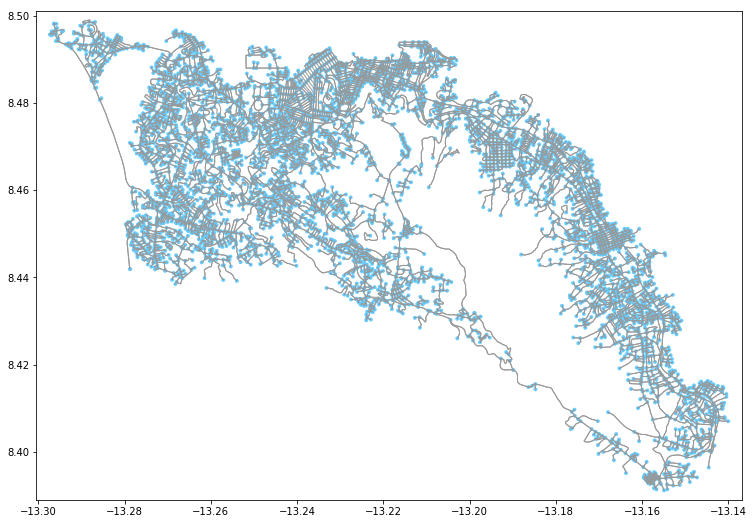

In [22]:
polygon = boundary2['geometry'].iloc[0]
G = ox.simplify_graph(ox.graph_from_polygon(polygon, network_type='drive_service', simplify=False))
fig, ax = ox.plot_graph(G,bbox=None, fig_height=9, fig_width=14,
                      margin=0.02, bgcolor='w', axis_off=False, show=True,
                      save=False, close=True, file_format='png', filename='temp',
                      dpi=300, annotate=False)

Calculate routes between each centroid pair:

In [23]:
#index list of centroid coordinates
centroids = gpd.read_file(path+'vorshape_clip_centroid.shp')
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = centroids['geometry']
x,y = [list(t) for t in zip(*map(getXY, centroidseries))]
centroidcoords = list(zip(centroids.index,y,x))

#create list of routes based on nearest nodes to centroids
route_list = []
for i in range(0,len(centroidcoords)):
    origin_point = centroidcoords[i][1:]
    origin_node = ox.get_nearest_node(G, origin_point)
    for j in range(i+1,len(centroidcoords)):
        destination_point = centroidcoords[j][1:]
        destination_node = ox.get_nearest_node(G, destination_point)
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')
        route_list.append(route)

Plot routes in the same graph:

In [24]:
def plot_graph_routes(G, routes, bbox=None, fig_height=9, fig_width=14,
                      margin=0.02, bgcolor='w', axis_off=False, show=True,
                      save=False, close=True, file_format='png', filename='temp',
                      dpi=300, annotate=False, node_color='#999999',
                      node_size=15, node_alpha=1, node_edgecolor='none',
                      node_zorder=1, edge_color='#999999', edge_linewidth=1,
                      edge_alpha=0.1, use_geom=True, orig_dest_points=None,
                      route_color='r', route_linewidth=5,
                      route_alpha=0.005, orig_dest_node_alpha=0.5,
                      orig_dest_node_size=50, orig_dest_node_color='b',
                      orig_dest_point_color='b'):
    """
    Plot several routes along a networkx spatial graph.
     Parameters
    ----------
    G : networkx multidigraph
    routes : list
        the routes as a list of lists of nodes
    bbox : tuple
        bounding box as north,south,east,west - if None will calculate from
        spatial extents of data. if passing a bbox, you probably also want to
        pass margin=0 to constrain it.
    fig_height : int
        matplotlib figure height in inches
    fig_width : int
        matplotlib figure width in inches
    margin : float
        relative margin around the figure
    axis_off : bool
        if True turn off the matplotlib axis
    bgcolor : string
        the background color of the figure and axis
    show : bool
        if True, show the figure
    save : bool
        if True, save the figure as an image file to disk
    close : bool
        close the figure (only if show equals False) to prevent display
    file_format : string
        the format of the file to save (e.g., 'jpg', 'png', 'svg')
    filename : string
        the name of the file if saving
    dpi : int
        the resolution of the image file if saving
    annotate : bool
        if True, annotate the nodes in the figure
    node_color : string
        the color of the nodes
    node_size : int
        the size of the nodes
    node_alpha : float
        the opacity of the nodes
    node_edgecolor : string
        the color of the node's marker's border
    node_zorder : int
        zorder to plot nodes, edges are always 2, so make node_zorder 1 to plot
        nodes beneath them or 3 to plot nodes atop them
    edge_color : string
        the color of the edges' lines
    edge_linewidth : float
        the width of the edges' lines
    edge_alpha : float
        the opacity of the edges' lines
    use_geom : bool
        if True, use the spatial geometry attribute of the edges to draw
        geographically accurate edges, rather than just lines straight from node
        to node
    orig_dest_points : list of tuples
        optional, a group of (lat, lon) points to plot instead of the
        origins and destinations of each route nodes
    route_color : string
        the color of the route
    route_linewidth : int
        the width of the route line
    route_alpha : float
        the opacity of the route line
    orig_dest_node_alpha : float
        the opacity of the origin and destination nodes
    orig_dest_node_size : int
        the size of the origin and destination nodes
    orig_dest_node_color : string
        the color of the origin and destination nodes
    orig_dest_point_color : string
        the color of the origin and destination points if being plotted instead
        of nodes
     Returns
    -------
    fig, ax : tuple
    """
     # plot the graph but not the routes
    fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=fig_height, fig_width=fig_width,
                         margin=margin, axis_off=axis_off, bgcolor=bgcolor,
                         show=False, save=False, close=False, filename=filename,
                         dpi=dpi, annotate=annotate, node_color=node_color,
                         node_size=node_size, node_alpha=node_alpha,
                         node_edgecolor=node_edgecolor, node_zorder=node_zorder,
                         edge_color=edge_color, edge_linewidth=edge_linewidth,
                         edge_alpha=edge_alpha, use_geom=use_geom)
     # save coordinates of the given reference points
    orig_dest_points_lats = []
    orig_dest_points_lons = []
    if orig_dest_points is None:
        # if caller didn't pass points, use the first and last node in each route as
        # origin/destination points
        for route in routes:
            origin_node = route[0]
            destination_node = route[-1]
            orig_dest_points_lats.append(G.nodes[origin_node]['y'])
            orig_dest_points_lats.append(G.nodes[destination_node]['y'])
            orig_dest_points_lons.append(G.nodes[origin_node]['x'])
            orig_dest_points_lons.append(G.nodes[destination_node]['x'])
    else:
        # otherwise, use the passed points as origin/destination points
        for point in orig_dest_points:
            orig_dest_points_lats.append(point[0])
            orig_dest_points_lons.append(point[1])
        orig_dest_node_color = orig_dest_point_color
     # scatter the origin and destination points
    ax.scatter(orig_dest_points_lons, orig_dest_points_lats, s=orig_dest_node_size,
               c=orig_dest_node_color, alpha=orig_dest_node_alpha, edgecolor=node_edgecolor, zorder=4)
     # plot the routes lines
    lines = []
    for route in routes:
        edge_nodes = list(zip(route[:-1], route[1:]))
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
             # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data and use_geom:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
     # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=route_color, linewidths=route_linewidth, alpha=route_alpha, zorder=3)
    ax.add_collection(lc)
     # save and show the figure as specified
    fig, ax = ox.plot.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax

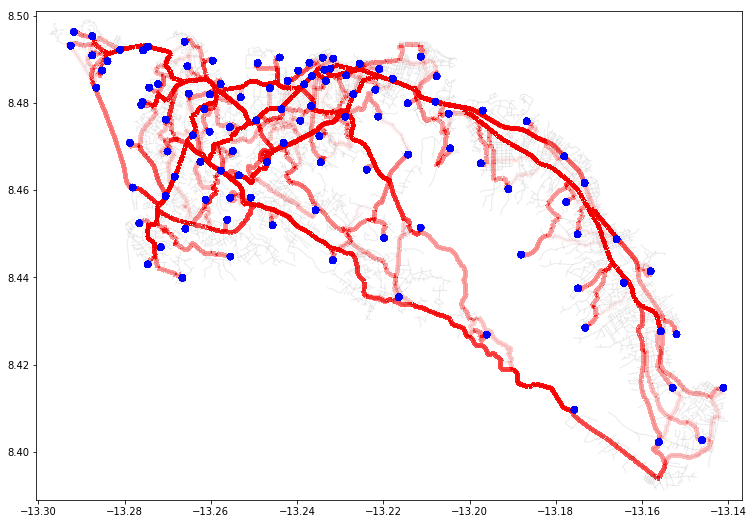

(<Figure size 1008x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc240a179e8>)

In [25]:
plot_graph_routes(G,route_list, node_size=0)


Determine weights for origin and destination nodes:

In [26]:
centroidcoordsdf = pd.DataFrame(centroidcoords)

#Append nearest node to each centroid
for i in range(0,len(centroidcoordsdf)):
    point = (centroidcoordsdf.ix[i,1],centroidcoordsdf.ix[i,2])
    centroidcoordsdf.ix[i,3]=ox.get_nearest_node(G, point)
centroidcoordsdf.head()

0         1          2             3
0  0  8.496026 -13.286721  3.123483e+08
1  1  8.493126 -13.280958  3.123493e+08
2  2  8.493371 -13.273676  3.108339e+09
3  3  8.493046 -13.273877  3.108339e+09
4  4  8.491828 -13.275076  3.108338e+09

In [27]:
#Merge to add nearest node to origin centroid
data2 = data.merge(centroidcoordsdf,left_on = 'Id of the origin(0 to 110)',right_on = 0,how = 'outer')
data2.head()

Id of the origin(0 to 110)  Id of the destination(0 to 110)  \
0                           0                                1   
1                           0                                2   
2                           0                                3   
3                           0                                4   
4                           0                                5   

   Number of trips from origin to destination  0         1          2  \
0                                  294.925694  0  8.496026 -13.286721   
1                                    0.000000  0  8.496026 -13.286721   
2                                    5.200072  0  8.496026 -13.286721   
3                                    0.000000  0  8.496026 -13.286721   
4                                    6.852800  0  8.496026 -13.286721   

             3  
0  312348284.0  
1  312348284.0  
2  312348284.0  
3  312348284.0  
4  312348284.0

In [28]:
#Merge to add nearest node to destination centroid
data3 = data2.merge(centroidcoordsdf,left_on = 'Id of the destination(0 to 110)',right_on = 0,how = 'outer')
data3.head()

Id of the origin(0 to 110)  Id of the destination(0 to 110)  \
0                           0                                1   
1                           2                                1   
2                           3                                1   
3                           4                                1   
4                           5                                1   

   Number of trips from origin to destination  0_x       1_x        2_x  \
0                                  294.925694    0  8.496026 -13.286721   
1                                    0.000000    2  8.493371 -13.273676   
2                                    0.000000    3  8.493046 -13.273877   
3                                    0.000000    4  8.491828 -13.275076   
4                                  292.956560    5  8.487432 -13.283790   

            3_x  0_y       1_y        2_y          3_y  
0  3.123483e+08    1  8.493126 -13.280958  312349332.0  
1  3.108339e+09    1  8.493126 -13.280958  312349332.0  
2  3.108339e+09    1  8.493126 -13.280958  312349332.0  
3  3.108338e+09    1  8.493126 -13.280958  312349332.0  
4  3.025157e+09    1  8.493126 -13.280958  312349332.0

In [29]:
#Remove extraneous data
data4 = data3.iloc[:,[6,10,2]]
data4.columns = ['NodeO','NodeD','Trips']
data4.head()

NodeO        NodeD       Trips
0  3.123483e+08  312349332.0  294.925694
1  3.108339e+09  312349332.0    0.000000
2  3.108339e+09  312349332.0    0.000000
3  3.108338e+09  312349332.0    0.000000
4  3.025157e+09  312349332.0  292.956560

In [30]:
#Remove zero trip rows
data5 = data4[data4.Trips != 0]
data5.head()

NodeO        NodeD       Trips
0   3.123483e+08  312349332.0  294.925694
4   3.025157e+09  312349332.0  292.956560
9   3.025229e+09  312349332.0  154.991945
10  3.025229e+09  312349332.0  191.200809
11  3.025373e+09  312349332.0  492.315439

Assign weights to links:

In [31]:
#Create route list only for nodes with trips, including trip weights
route_list2 = []
for i in range(0,len(data5)):
    origin_node = data5.iloc[i,0]
    destination_node = data5.iloc[i,1]
    trips = data5.iloc[i,2]
    route = nx.shortest_path(G, origin_node, destination_node, weight='length')
    route_list2.append([route,trips])

In [32]:
#Create new attribute for edge list called "weight"
for i in range(0,len(route_list2)):
    for j in range(0,len(route_list2[i][0])-1):
        u = (route_list2[i][0][j])
        v = (route_list2[i][0][j+1])
        G[u][v][0]['weight'] = 0

In [33]:
#Loop through each link in the route and add demand as weight
for i in range(0,len(route_list2)):
    for j in range(0,len(route_list2[i][0])-1):
        u = (route_list2[i][0][j])
        v = (route_list2[i][0][j+1])
        G[u][v][0]['weight'] = G[u][v][0]['weight']+route_list2[i][1]
        G[u][v][0]['weight']=G[u][v][0]['weight'].item()

Export data to csv:

In [34]:
edge_attributes = ox.graph_to_gdfs(G, nodes=False)
edge_attributes['weight'].fillna(0, inplace=True)
edge_attributes.head()

bridge                                           geometry      highway  \
0    NaN  LINESTRING (-13.1925328 8.4697891, -13.192572 ...  residential   
1    NaN  LINESTRING (-13.1925328 8.4697891, -13.1925281...  residential   
2    NaN  LINESTRING (-13.1925328 8.4697891, -13.1936227...  residential   
3    NaN  LINESTRING (-13.187353 8.465672700000001, -13....      service   
4    NaN  LINESTRING (-13.1544845 8.3944004, -13.1544242...  residential   

  junction  key lanes   length maxspeed             name  oneway      osmid  \
0      NaN    0   NaN   77.412      NaN     FRIST STREET   False   28459470   
1      NaN    0   NaN   78.072      NaN     FRIST STREET   False   28459470   
2      NaN    0   NaN  119.928      NaN    Albion Street   False   33046561   
3      NaN    0   NaN   35.487      NaN              NaN   False  307872986   
4      NaN    0   NaN   51.611      NaN  Black Hall Road   False  242583315   

   ref service tunnel           u           v  weight  
0  NaN     NaN    NaN   372637709   372633823     0.0  
1  NaN     NaN    NaN   372637709   312661315     0.0  
2  NaN     NaN    NaN   372637709   372640631     0.0  
3  NaN   alley    NaN  3131047985  3046425537     0.0  
4  NaN     NaN    NaN  3041984562  2500506747     0.0

In [35]:
node_attributes = ox.graph_to_gdfs(G, edges=False)
node_attributes.head()

highway       osmid        x        y  \
372637709      NaN   372637709 -13.1925  8.46979   
3131047985     NaN  3131047985 -13.1874  8.46567   
3041984562     NaN  3041984562 -13.1545   8.3944   
393740345      NaN   393740345 -13.2755  8.49311   
3041984567     NaN  3041984567 -13.1545  8.39659   

                                        geometry  
372637709          POINT (-13.1925328 8.4697891)  
3131047985  POINT (-13.187353 8.465672700000001)  
3041984562         POINT (-13.1544845 8.3944004)  
393740345           POINT (-13.275477 8.4931065)  
3041984567          POINT (-13.1545324 8.396587)

In [36]:
edge_attributes.to_csv(path+'edge_attributes.csv')
node_attributes.to_csv(path+'node_attributes.csv')

# NOTE:

Trying to calculate network statistics for the road network consistently crashed the kernel for Python 3. I had to export the data to csv in order to run on the version I had installed locally on my computer, which is Python 2. CSV data was additionally reformatted as a text file for upload to Python 2. That notebook is attached separately.

# Perform additional network analysis

Upload files with data processed in Python 2:

In [37]:
nodes = gpd.GeoDataFrame(pd.read_csv(path+'node_attributes2.csv'))
edges = gpd.GeoDataFrame(pd.read_csv(path+'edge_attributes2.csv'))

In [38]:
#Force gdf to recognize geometry columns correctly
nodes['geometry'] = nodes['geometry'].apply(lambda x: loads(x))
edges['geometry'] = edges['geometry'].apply(lambda x: loads(x))

Categorize nodes by the percentile of their weighted degree and betweenness centrality:

In [39]:
nodes.head()

osmid          x         y  degree  degree_weighted        bc  \
0   372637709 -13.192533  8.469789       3          0.00000  0.001357   
1  3131047985 -13.187353  8.465673       1          0.00000  0.000000   
2  3041984562 -13.154485  8.394400       3          0.00000  0.001494   
3   393740345 -13.275477  8.493106       3      20905.02832  0.046766   
4  3041984567 -13.154532  8.396587       3          0.00000  0.002952   

         cl                              geometry  
0  0.000127         POINT (-13.1925328 8.4697891)  
1  0.000111  POINT (-13.187353 8.465672700000001)  
2  0.000079         POINT (-13.1544845 8.3944004)  
3  0.000109          POINT (-13.275477 8.4931065)  
4  0.000079          POINT (-13.1545324 8.396587)

In [40]:
k75 = nodes['degree_weighted'].quantile(0.75)
bc75 = nodes['bc'].quantile(0.75)

In [41]:
catlist =[]
for i in range(0,len(nodes)):
    if nodes.iloc[i,4] >= k75:
        if nodes.iloc[i,5] >= bc75:
            catlist.append(3)
        else:
            catlist.append(1)
    elif nodes.iloc[i,5] >= bc75:
        catlist.append(2)
    else:
        catlist.append(0)
nodes['Cat']=catlist
nodes.head()

osmid          x         y  degree  degree_weighted        bc  \
0   372637709 -13.192533  8.469789       3          0.00000  0.001357   
1  3131047985 -13.187353  8.465673       1          0.00000  0.000000   
2  3041984562 -13.154485  8.394400       3          0.00000  0.001494   
3   393740345 -13.275477  8.493106       3      20905.02832  0.046766   
4  3041984567 -13.154532  8.396587       3          0.00000  0.002952   

         cl                              geometry  Cat  
0  0.000127         POINT (-13.1925328 8.4697891)    0  
1  0.000111  POINT (-13.187353 8.465672700000001)    0  
2  0.000079         POINT (-13.1544845 8.3944004)    0  
3  0.000109          POINT (-13.275477 8.4931065)    3  
4  0.000079          POINT (-13.1545324 8.396587)    0

Categorize edges by the percentile of their weighted degree and betweenness centrality:

In [42]:
edges.head()

u           v  bridge      highway junction  lanes   length  \
0   372637709   372633823       0  residential      NaN    NaN   77.412   
1   372637709   312661315       0  residential      NaN    NaN   78.072   
2   372637709   372640631       0  residential      NaN    NaN  119.928   
3  3131047985  3046425537       0      service      NaN    NaN   35.487   
4  3041984562  2500506747       0  residential      NaN    NaN   51.611   

   maxspeed             name  oneway      osmid  ref service tunnel  weight  \
0       NaN     FRIST STREET   False   28459470  NaN     NaN    NaN     0.0   
1       NaN     FRIST STREET   False   28459470  NaN     NaN    NaN     0.0   
2       NaN    Albion Street   False   33046561  NaN     NaN    NaN     0.0   
3       NaN          Unknown   False  307872986  NaN   alley    NaN     0.0   
4       NaN  Black Hall Road   False  242583315  NaN     NaN    NaN     0.0   

   edgebetw                                           geometry  
0  0.001628  LINESTRING (-13.1925328 8.4697891, -13.192572 ...  
1  0.001360  LINESTRING (-13.1925328 8.4697891, -13.1925281...  
2  0.000007  LINESTRING (-13.1925328 8.4697891, -13.1936227...  
3  0.000281  LINESTRING (-13.187353 8.465672700000001, -13....  
4  0.001660  LINESTRING (-13.1544845 8.3944004, -13.1544242...

In [43]:
print(edges['weight'].min())
print(edges['weight'].quantile(0.25))
print(edges['weight'].quantile(0.5))
print(edges['weight'].quantile(0.75))
print(edges['weight'].quantile(0.80))
print(edges['weight'].quantile(0.85))
print(edges['weight'].max())
print(edges['weight'].mean())

0.0
0.0
0.0
800.2233247
2057.4468920000004
3469.367549
119131.0987
2433.4043372903047


In [44]:
print(edges['edgebetw'].min())
print(edges['edgebetw'].quantile(0.25))
print(edges['edgebetw'].quantile(0.5))
print(edges['edgebetw'].quantile(0.75))
print(edges['edgebetw'].quantile(0.80))
print(edges['edgebetw'].quantile(0.85))
print(edges['edgebetw'].max())
print(edges['edgebetw'].mean())

0.0
0.000280978
0.000842697
0.004053195
0.006163271999999999
0.010240233
0.367112719
0.011159654566452548


In [45]:
kbench = edges['weight'].quantile(0.85)
bbench = edges['edgebetw'].quantile(0.85)

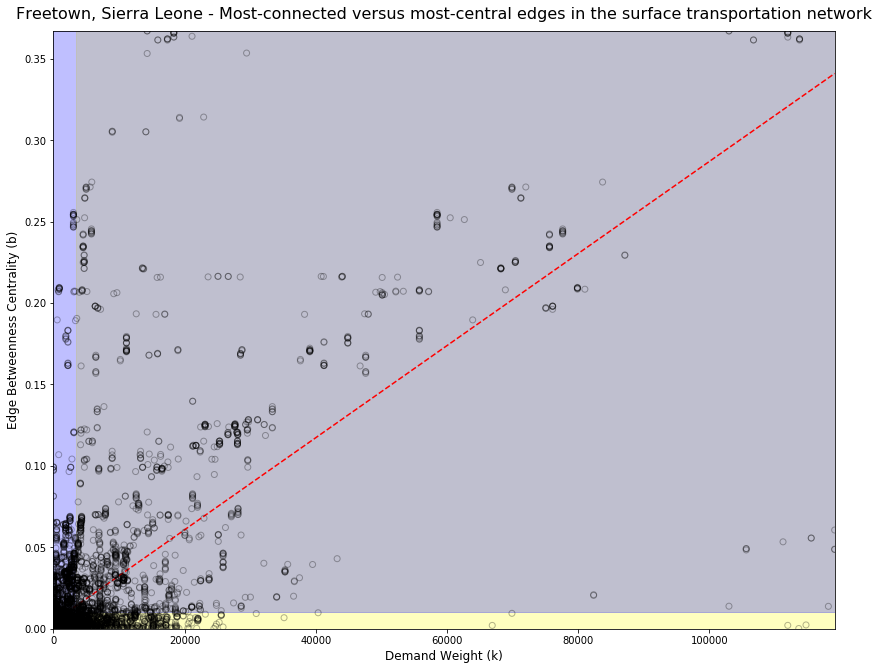

In [46]:
fig, ax = plt.subplots(figsize=(14,11))
plt.scatter(edges['weight'], edges['edgebetw'], s=None, c='None', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.3, linewidths=None, verts=None, edgecolors='black',zorder=20)
plt.plot(np.unique(edges['weight']), np.poly1d(np.polyfit(edges['weight'], edges['edgebetw'], 1))(np.unique(edges['weight'])),linestyle='dashed',c='red',zorder=10)
ax.axvspan(kbench, edges['weight'].max(),alpha=0.25, color='yellow')
ax.axhspan(bbench, edges['edgebetw'].max(),alpha=0.25, color='blue')
plt.title("Freetown, Sierra Leone - Most-connected versus most-central edges in the surface transportation network", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center', 
    pad=12)
plt.ylim(0,edges['edgebetw'].max())
plt.xlim(0,edges['weight'].max())
plt.xlabel('Demand Weight (k)',
    fontdict={'fontsize': 12})
plt.ylabel('Edge Betweenness Centrality (b)',
    fontdict={'fontsize': 12})
plt.show()

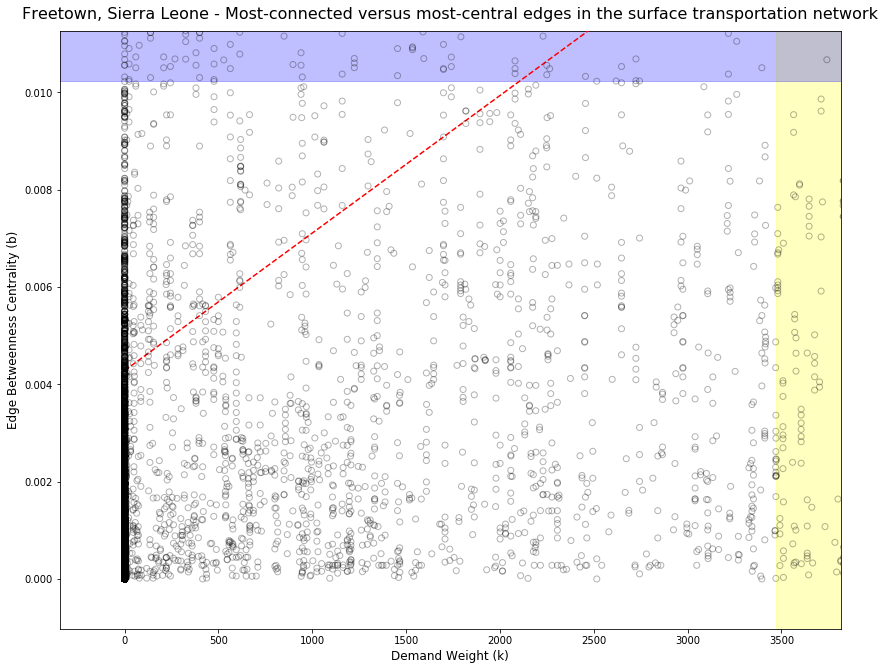

In [47]:
fig, ax = plt.subplots(figsize=(14,11))
plt.scatter(edges['weight'], edges['edgebetw'], s=None, c='None', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.3, linewidths=None, verts=None, edgecolors='black',zorder=20)
plt.plot(np.unique(edges['weight']), np.poly1d(np.polyfit(edges['weight'], edges['edgebetw'], 1))(np.unique(edges['weight'])),linestyle='dashed',c='red',zorder=10)
ax.axvspan(kbench, edges['weight'].max(),alpha=0.25, color='yellow')
ax.axhspan(bbench, edges['edgebetw'].max(),alpha=0.25, color='blue')
plt.title("Freetown, Sierra Leone - Most-connected versus most-central edges in the surface transportation network", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center', 
    pad=12)
plt.ylim(bbench*-.1,bbench*1.1)
plt.xlim(kbench*-.1,kbench*1.1)
plt.xlabel('Demand Weight (k)',
    fontdict={'fontsize': 12})
plt.ylabel('Edge Betweenness Centrality (b)',
    fontdict={'fontsize': 12})
plt.show()

In [48]:
catliste =[]
for i in range(0,len(edges)):
    if edges.iloc[i,14] >= kbench:
        if edges.iloc[i,15] >= bbench:
            catliste.append(3)
        else:
            catliste.append(1)
    elif edges.iloc[i,5] >= bbench:
        catliste.append(2)
    else:
        catliste.append(0)
edges['Cat']=catliste
edges.head()

u           v  bridge      highway junction  lanes   length  \
0   372637709   372633823       0  residential      NaN    NaN   77.412   
1   372637709   312661315       0  residential      NaN    NaN   78.072   
2   372637709   372640631       0  residential      NaN    NaN  119.928   
3  3131047985  3046425537       0      service      NaN    NaN   35.487   
4  3041984562  2500506747       0  residential      NaN    NaN   51.611   

   maxspeed             name  oneway      osmid  ref service tunnel  weight  \
0       NaN     FRIST STREET   False   28459470  NaN     NaN    NaN     0.0   
1       NaN     FRIST STREET   False   28459470  NaN     NaN    NaN     0.0   
2       NaN    Albion Street   False   33046561  NaN     NaN    NaN     0.0   
3       NaN          Unknown   False  307872986  NaN   alley    NaN     0.0   
4       NaN  Black Hall Road   False  242583315  NaN     NaN    NaN     0.0   

   edgebetw                                           geometry  Cat  
0  0.001628  LINESTRING (-13.1925328 8.4697891, -13.192572 ...    0  
1  0.001360  LINESTRING (-13.1925328 8.4697891, -13.1925281...    0  
2  0.000007  LINESTRING (-13.1925328 8.4697891, -13.1936227...    0  
3  0.000281  LINESTRING (-13.187353 8.465672700000001, -13....    0  
4  0.001660  LINESTRING (-13.1544845 8.3944004, -13.1544242...    0

In [49]:
catliste2 =[]
for i in range(0,len(edges)):
    if edges.iloc[i,17] == 3:
        catliste2.append("Connector")
    elif edges.iloc[i,17] == 2:
        catliste2.append("Peripheral Connector")
    elif edges.iloc[i,17]== 1:
        catliste2.append('Attractor')
    else:
        catliste2.append('Local')
edges['Cat2']=catliste2
edges.head()

u           v  bridge      highway junction  lanes   length  \
0   372637709   372633823       0  residential      NaN    NaN   77.412   
1   372637709   312661315       0  residential      NaN    NaN   78.072   
2   372637709   372640631       0  residential      NaN    NaN  119.928   
3  3131047985  3046425537       0      service      NaN    NaN   35.487   
4  3041984562  2500506747       0  residential      NaN    NaN   51.611   

   maxspeed             name  oneway      osmid  ref service tunnel  weight  \
0       NaN     FRIST STREET   False   28459470  NaN     NaN    NaN     0.0   
1       NaN     FRIST STREET   False   28459470  NaN     NaN    NaN     0.0   
2       NaN    Albion Street   False   33046561  NaN     NaN    NaN     0.0   
3       NaN          Unknown   False  307872986  NaN   alley    NaN     0.0   
4       NaN  Black Hall Road   False  242583315  NaN     NaN    NaN     0.0   

   edgebetw                                           geometry  Cat   Cat2  
0  0.001628  LINESTRING (-13.1925328 8.4697891, -13.192572 ...    0  Local  
1  0.001360  LINESTRING (-13.1925328 8.4697891, -13.1925281...    0  Local  
2  0.000007  LINESTRING (-13.1925328 8.4697891, -13.1936227...    0  Local  
3  0.000281  LINESTRING (-13.187353 8.465672700000001, -13....    0  Local  
4  0.001660  LINESTRING (-13.1544845 8.3944004, -13.1544242...    0  Local

Export for use in Carto visualizations:

In [ ]:
edges.to_csv(path+'edgescarto.csv')

# Data analysis and visualization

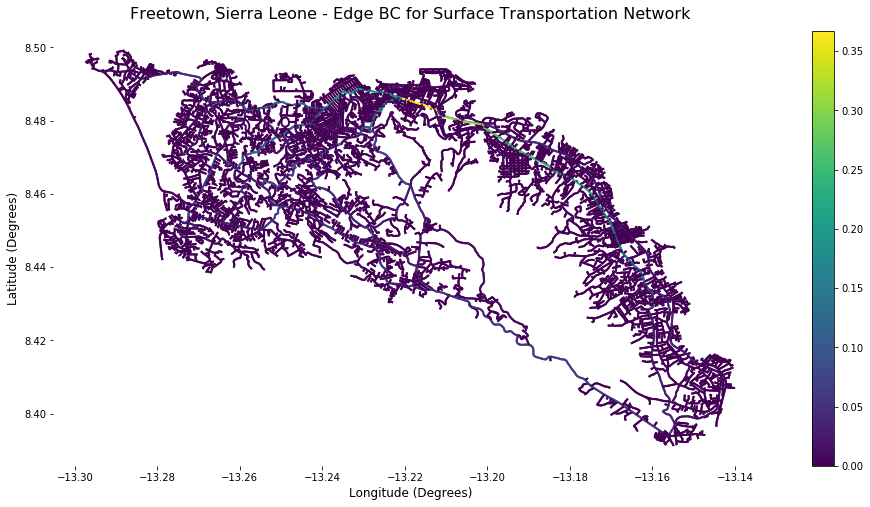

In [50]:
fig, ax = plt.subplots(figsize=(16,8))
#ax.set_facecolor('xkcd:black')
#nodes.plot(ax=ax,column='Cat',cmap='viridis', markersize=15,legend=True,zorder=20);
edges.plot(ax=ax,column='edgebetw',cmap='viridis', linewidth=2,legend=True);
#vorshape_clip.plot(ax=ax, color='none', edgecolor='gray',alpha=0.5,linewidth=.5,zorder=15);
#boundary3.plot(ax=ax,color='none', edgecolor='gray', alpha=0.5,linewidth=2,zorder=25);
#centroids.plot(ax=ax,color='white',edgecolor='white',markersize=20,zorder=20);
plt.title("Freetown, Sierra Leone - Edge BC for Surface Transportation Network", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center', 
    pad=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlabel('Longitude (Degrees)',
    fontdict={'fontsize': 12})
plt.ylabel('Latitude (Degrees)',
    fontdict={'fontsize': 12})
plt.show()

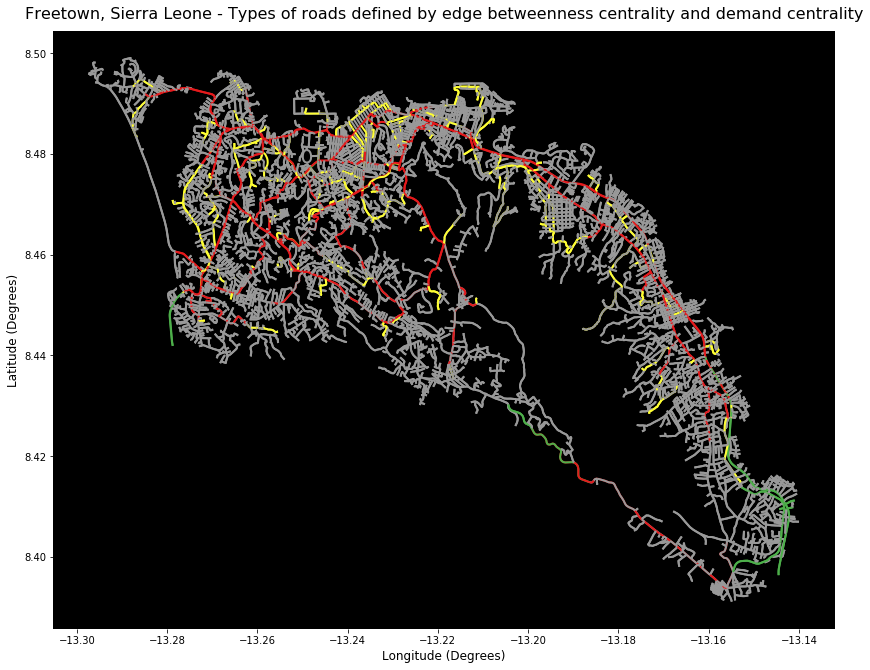

In [51]:
fig, ax = plt.subplots(figsize=(14,11))
ax.set_facecolor('xkcd:black')
edges.plot(ax=ax,column='Cat',cmap='Set1_r', linewidth=2,legend=False);
#vorshape_clip.plot(ax=ax, color='none', edgecolor='gray',alpha=0.5,linewidth=.5,zorder=15);
#boundary3.plot(ax=ax,color='none', edgecolor='gray', alpha=0.5,linewidth=2,zorder=25);
#centroids.plot(ax=ax,color='white',edgecolor='white',markersize=20,zorder=20);
plt.title("Freetown, Sierra Leone - Types of roads defined by edge betweenness centrality and demand centrality", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center', 
    pad=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlabel('Longitude (Degrees)',
    fontdict={'fontsize': 12})
plt.ylabel('Latitude (Degrees)',
    fontdict={'fontsize': 12})
plt.show()

Text(0, 0.5, 'Frequency')

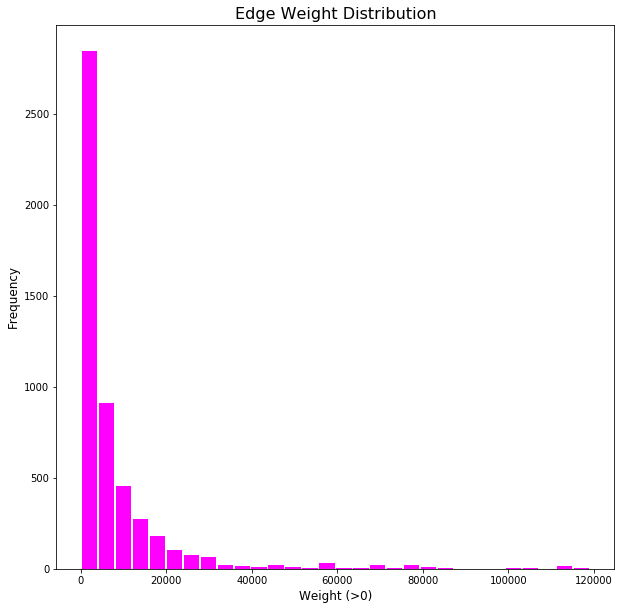

In [58]:
dem = dict(edges.weight).values()

fig = plt.figure(figsize=(10,10))
plt.hist(dem,bins=30,range=(0.000000001,max(edges.weight)),rwidth=0.9,color = 'magenta')
plt.title("Edge Weight Distribution", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center')
plt.xlabel("Weight (>0)",
    fontdict={'fontsize': 12})
plt.ylabel("Frequency",
    fontdict={'fontsize': 12})

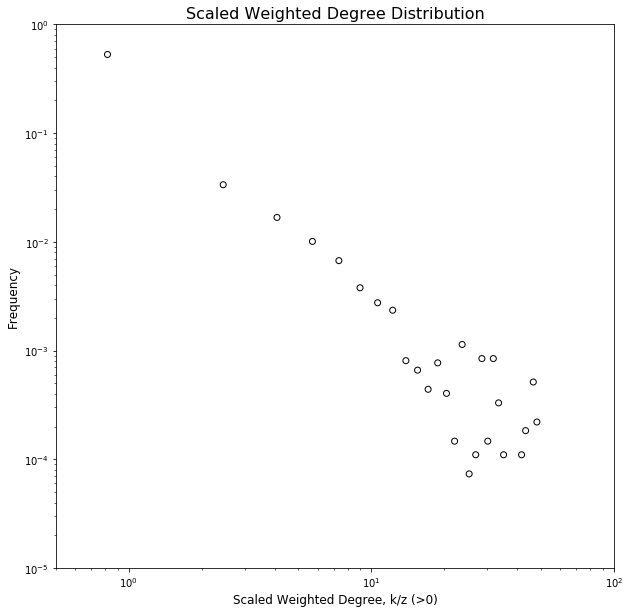

In [221]:
fig,ax = plt.subplots(figsize=(10,10))
data,binEdges = np.histogram(edges.weight/edges.weight.mean(),bins=30,density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.scatter(bincenters, data,s=None, c='None', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=None, verts=None, edgecolors='black',zorder=20)

plt.title("Scaled Weighted Degree Distribution", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center')
plt.xlabel("Scaled Weighted Degree, k/z (>0)",
    fontdict={'fontsize': 12})
plt.ylabel("Frequency",
    fontdict={'fontsize': 12})
plt.ylim(.00001,1)
plt.xlim(.5,100)
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')

In [222]:
def fitfunc(p, x):
    return p[0] * (x ** p[1])
def errfunc(p, x, y):
    return y - fitfunc(p, x)

qout,success = optimize.leastsq(errfunc, [max(data),-1,-0.5],
                               args=(bincenters[1:], data[1:]),maxfev=3000)

out = qout[:]
out[0] = qout[0] * (1**qout[1])
out[1] = qout[1]
#print "%g + %g*x^%g"%(out[0],out[1],out[2])
print (str(out[0])+" * x^"+str(out[1]))

0.14421217599158173 * x^-1.6043142982719094


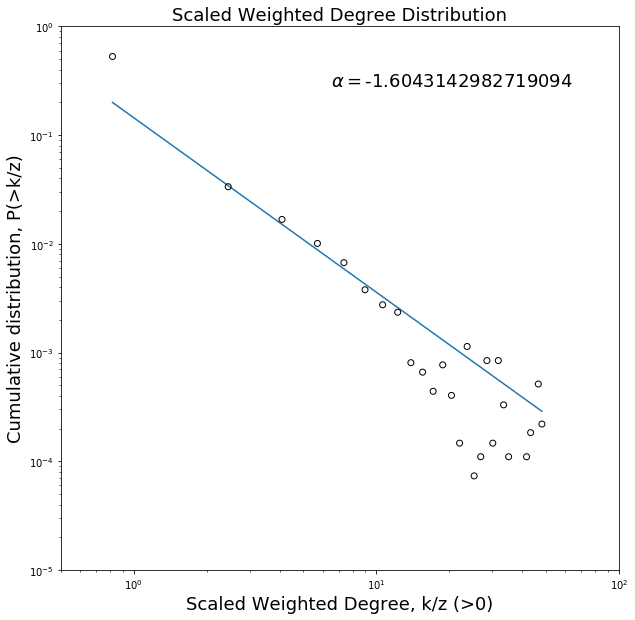

In [225]:
dem = dict(edges.weight/edges.weight.mean()).values()

fig,ax = plt.subplots(figsize=(10,10))
data,binEdges = np.histogram(edges.weight/edges.weight.mean(),bins=30,density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.scatter(bincenters, data,s=None, c='None', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=None, verts=None, edgecolors='black',zorder=20)
plt.plot(bincenters,0.14421217599158173 *bincenters**-1.6043142982719094)
plt.text(0.7, 0.9, r'$\alpha = $'+str(out[1]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize = 18)
#plt.scatter(bincenters,0.3221854428229404  *bincenters**-2.4288630673379767)
plt.title("Scaled Weighted Degree Distribution", 
    fontdict={'fontsize': 18,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center')
plt.xlabel("Scaled Weighted Degree, k/z (>0)",
    fontdict={'fontsize': 18})
plt.ylabel("Cumulative distribution, P(>k/z)",
    fontdict={'fontsize': 18})
plt.ylim(.00001,1)
plt.xlim(.5,100)
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')

Text(0, 0.5, 'Cumulative distribution, P(>b)')

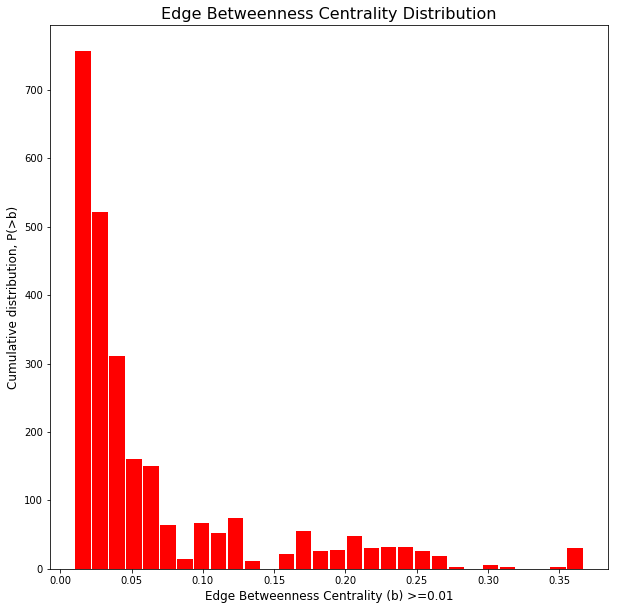

In [163]:
dem = dict(edges.edgebetw).values()

fig = plt.figure(figsize=(10,10))
plt.hist(dem,bins=30,range=(0.01,max(edges.edgebetw)),rwidth=0.9,color = 'red')
plt.title("Edge Betweenness Centrality Distribution", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center')
plt.xlabel("Edge Betweenness Centrality (>=0.01)",
    fontdict={'fontsize': 12})
plt.ylabel("Frequency",
    fontdict={'fontsize': 12})

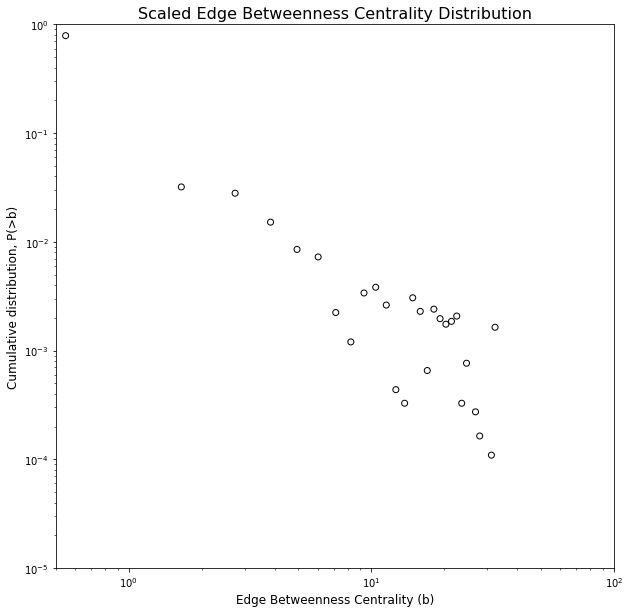

In [215]:
fig,ax = plt.subplots(figsize=(10,10))
data,binEdges = np.histogram(edges.edgebetw/edges.edgebetw.mean(),bins=30,density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.scatter(bincenters, data,s=None, c='None', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=None, verts=None, edgecolors='black',zorder=20)

plt.title("Scaled Edge Betweenness Centrality Distribution", 
    fontdict={'fontsize': 16,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center')
plt.xlabel("Edge Betweenness Centrality (b)",
    fontdict={'fontsize': 12})
plt.ylabel("Cumulative distribution, P(>b)",
    fontdict={'fontsize': 12})
plt.ylim(.00001,1)
plt.xlim(0.5,100)
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')

In [218]:
qout,success = optimize.leastsq(errfunc, [max(data),-1,-0.5],
                               args=(bincenters[1:], data[1:]),maxfev=3000)

out = qout[:]
out[0] = qout[0] * (1**qout[1])
out[1] = qout[1]
#print "%g + %g*x^%g"%(out[0],out[1],out[2])
print (str(out[0])+" * x^"+str(out[1]))

0.06633240861037414 * x^-1.2380517165663611


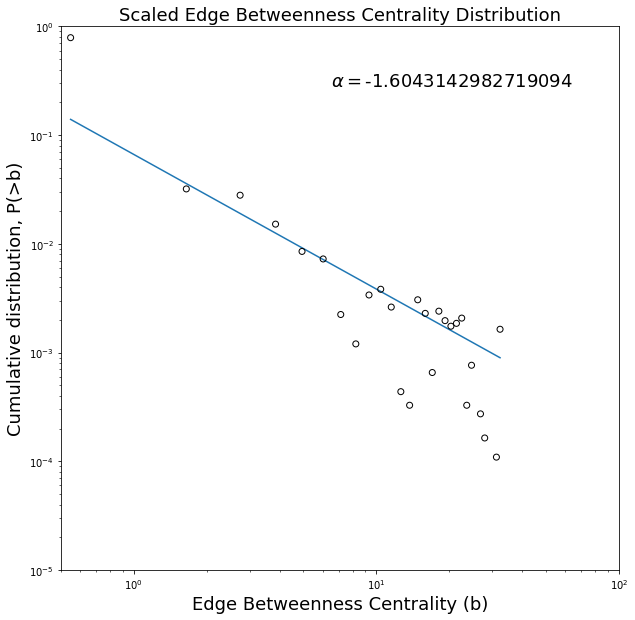

In [227]:
fig,ax = plt.subplots(figsize=(10,10))
data,binEdges = np.histogram(edges.edgebetw/edges.edgebetw.mean(),bins=30,density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.scatter(bincenters, data,s=None, c='None', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=None, verts=None, edgecolors='black',zorder=20)
#plt.plot(bincenters,0.002368341576442988 +0.14893971159224353  *bincenters**-2.7659616703020857)
plt.plot(bincenters,0.06633240861037414    *bincenters**-1.2380517165663611)
plt.text(0.7, 0.9, r'$\alpha = $'+str(out[1]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize = 18)
plt.title("Scaled Edge Betweenness Centrality Distribution", 
    fontdict={'fontsize': 18,
        'fontweight' : None,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}, 
    loc='center')
plt.xlabel("Edge Betweenness Centrality (b)",
    fontdict={'fontsize': 18})
plt.ylabel("Cumulative distribution, P(>b)",
    fontdict={'fontsize': 18})
plt.ylim(.00001,1)
plt.xlim(0.5,100)
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')